<a href="https://colab.research.google.com/github/trefftzc/L_system/blob/main/l_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The original source code was taken from:

https://github.com/Nightwind0/lsystems/blob/master/generate.py

In [1]:
!sudo apt install libcairo2-dev pkg-config


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev
  libglib2.0-dev libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev
  libmount1 libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev
  libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils libice-doc cryptsetup-bin libsm-doc
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev
  libglib2.0-dev libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev
  libpixman-1-dev libselinux1-dev libsepol-dev libsm-dev libxcb-render0-dev
  libxcb-shm0-dev
The following packages will be upgraded:
  libblkid1 libmount1
2 upgraded, 15 newly installed, 0 to re

In [2]:
!pip3 install --force-reinstall --no-cache-dir pycairo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.9/346.9 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycairo: filename=pycairo-1.26.0-cp310-cp310-linux_x86_64.whl size=320923 sha256=68585a3389891957a16153bad9840f7c56a7ebd59e99e769369e4373dac4f5e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-kx_ka9ab/wheels/e3/46/83/453eb7915b034ce1a9fee5a6023def2030633f6a73dc6d2de8
Successfully built pycairo


In [8]:
#!/usr/bin/env python
# Author: Daniel Palm
# Copyright 2018
#
# Implementation of L-Systems, using a simple "Turtle" for drawing, and cairo for generating a png.
# Based on LSystem definitions from wikipedia


import math
import cairo
import copy
import numpy as np


class Turtle:
    def __init__(self):
        self.loc = np.array([0.0,0.0])
        self.direction = np.array([1.0,0.0])
        self.penOn = True
        self.spacing = 0.02

    def setSpacing(self, width):
        self.spacing = width;
    def rotate(self, radians):
        c, s = np.cos(radians), np.sin(radians)
        j = np.matrix([[c,s], [-s, c]])
        m = np.dot(j, [self.direction[0],self.direction[1]])
        self.direction[0] = float(m.T[0])
        self.direction[1] = float(m.T[1])
    def penDown(self):
        self.penOn = True
    def penUp(self):
        self.penOn = False
    def forward(self, ctx):
        #print "fwd"
        newpt = self.loc + self.direction * self.spacing
        if self.penOn:
            #print "draw at %f, %f" % (newpt[0], newpt[1])
            ctx.move_to(self.loc[0], self.loc[1])
            ctx.set_line_width(self.spacing / 6.0)
            ctx.set_line_cap(cairo.LINE_CAP_ROUND)
            ctx.set_line_join(cairo.LINE_JOIN_ROUND)
            ctx.set_source_rgba(0,0,0,1)
            ctx.line_to(newpt[0], newpt[1])
            ctx.close_path()
            ctx.stroke()
        self.loc = newpt
    def turnLeft(self, degrees):
        self.rotate(-np.deg2rad(degrees))
    def turnRight(self, degrees):
        self.rotate(np.deg2rad(degrees))

class LSystem:
    FORWARD = 1
    TURNLEFT = 2
    TURNRIGHT = 3
    PUSH = 4
    POP = 5
    def __init__(self, name):
        self.stack = []
        self.input = ""
        self.rules = {}
        self.bindMap = {}
        self.name = name
        self.scale = 0.02
        self.angle = 90 #degrees
        self.turtle = self.newTurtle()
    def newTurtle(self):
        turtle = Turtle()
        turtle.penDown()
        turtle.setSpacing(self.scale)
        return turtle
    def setScale(self, scale):
        self.scale = scale
        self.turtle.setSpacing(self.scale)
    def doAction(self, action, ctx):
        #print("Doing action %s" % action)
        if action == LSystem.FORWARD:
            self.turtle.forward(ctx)
        elif action == LSystem.TURNLEFT:
            self.turtle.turnLeft(self.angle)
        elif action == LSystem.TURNRIGHT:
            self.turtle.turnRight(self.angle)
    def setAngle(self, angle):
        self.angle = angle
    def addRule(self, start, end):
        self.rules[start] = end
    def bind(self, c, action):
        self.bindMap[c] = action
    def handleChar(self, c, ctx):
        if ctx != None:
            if c == "[":
                #print "push copy"
                self.stack.append(copy.copy(self.turtle))
            elif c == "]":
                #print "pop copy"
                self.turtle = self.stack.pop()
            elif c == "+":
                self.turtle.turnLeft(self.angle)
            elif c == "-":
                self.turtle.turnRight(self.angle)
            if c in self.bindMap:
                self.doAction(self.bindMap[c], ctx)
        if c in self.rules:
            return self.rules[c]
        else:
            return c
    def setStart(self, start):
        self.input = start
    def step(self, ctx):
        newinput = ""
        for c in self.input:
            resp = self.handleChar(c, ctx)
            if resp != None:
                newinput += resp
        self.input = newinput
        print(self.input)
    def drawPng(self, steps, width, height, origin=(0.5,0.5)):
        surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
        ctx = cairo.Context(surface)
        ctx.scale(width, height)  # Normalizing the canvas

        pat = cairo.LinearGradient(0.0, 0.0, 0.0, 1.0)
        pat.add_color_stop_rgba(1, 0.62, 0.98, 1.0, 1.0)  # First stop, 50% opacity
        pat.add_color_stop_rgba(0, 0.404, 0.251, 0.588, 1)  # Last stop, 100% opacity

        ctx.rectangle(0, 0, 1, 1)  # Rectangle(x0, y0, x1, y1)
        ctx.set_source(pat)
        ctx.fill()
        ctx.translate(origin[0], origin[1])  # Changing the current transformation matrix
        for i in range(0,steps-1):
            self.step(None)
        self.step(ctx)
        surface.write_to_png(self.name + ".png")  # Output to PNG


striangle = LSystem("striangle")
striangle.setAngle(120)
striangle.setScale(0.005)
striangle.bind("F", LSystem.FORWARD)
striangle.bind("G", LSystem.FORWARD)
striangle.addRule("F", "F-G+F+G-F")
striangle.addRule("G", "GG")
striangle.setStart("F-G-G")
striangle.drawPng(6, 256, 256, (0.2, 0.7))

#striangle2 = LSystem("striangle2")
#striangle2.setAngle(60)
#striangle2.setScale(0.001)
#striangle2.bind("A", LSystem.FORWARD)
#striangle2.bind("B", LSystem.FORWARD)
#striangle2.addRule("A", "B-A-B")
#striangle2.addRule("B", "A+B+A")
#striangle2.setStart("A")
#striangle2.drawPng(11, 4096, 4096, (0.0, 0.0))

#dragon = LSystem("dragon")
#dragon.setAngle(90)
#dragon.bind("F", LSystem.FORWARD)
#dragon.addRule("X", "X+YF+")
#dragon.addRule("Y", "-FX-Y")
#dragon.setStart("FX")
#dragon.setScale(0.005)
#dragon.drawPng(16, 4096, 4096, (0.5, 0.77))

#plant = LSystem("plant")
#plant.setAngle(25)
#plant.setScale(0.001)
#plant.bind("F", LSystem.FORWARD)
#plant.addRule("X", "F+[[X]-X]-F[-FX]+X")
#plant.addRule("F", "FF")
#plant.setStart("X")
#plant.drawPng(10, 4096, 4096, (0.0, 0.5))

#"L", string rewriting rules "L" -> "+RF-LFL-FR+", "R" -> "-LF+RFR+FL-", and angle 90 degrees

#hilbert = LSystem("hilbert_curve")
#hilbert.setAngle(90)
#hilbert.setScale(0.005)
#hilbert.bind("F", LSystem.FORWARD)
#hilbert.addRule("L", "+RF-LFL-FR+")
#hilbert.addRule("R", "-LF+RFR+FL-")
#hilbert.setStart("L")
#hilbert.drawPng(9, 4096, 4096, (0.0,0.0))

#It is also a Lindenmayer system and the curve can be encoded with initial string "X", string rewriting rules "X" -> "XFYFX+F+YFXFY-F-XFYFX", "Y" -> "YFXFY-F#-XFYFX+F+YFXFY", and angle 90 degrees
#hilbert2 = LSystem("hilbert2_curve")
#hilbert2.setAngle(90)
#hilbert2.setScale(0.003)
#hilbert2.bind("F", LSystem.FORWARD)
#hilbert2.addRule("X", "XFYFX+F+YFXFY-F-XFYFX")
#hilbert2.addRule("Y", "YFXFY-F-XFYFX+F+YFXFY")
#hilbert2.setStart("X")
#hilbert2.drawPng(7, 4096, 4096, (0.0,0.0))

#Peano-Gosper curve (X -> X+YF++YF-FX--FXFX-YF+, Y -> -FX+YFYF++YF+FX--FX-Y, 60degrees)

#peano_gosper = LSystem("peano_gosper")
#peano_gosper.setAngle(60)
#peano_gosper.setScale(0.004)
#peano_gosper.bind("F", LSystem.FORWARD)
#peano_gosper.addRule("X", "X+YF++YF-FX--FXFX-YF+")
#peano_gosper.addRule("Y", "-FX+YFYF++YF+FX--FX-Y")
#peano_gosper.setStart("X")
#peano_gosper.drawPng(7, 4096, 4096, (0.7,0.4))

F-G+F+G-F-GG-GG
F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGG-GGGG
F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGGGGGG-GGGGGGGG
F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGGGGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGGGGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGGGGGGGGGGGGGG-GGGGGGGGGGGGGGGG
F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGGGGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGGGGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGG+F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F+GGGG-F-G+F+G-F-GG+F-G+F+G-F+GG-F-G+F+G-F-GGGGGGGGGGGGGGGG+F-G+F+G

<ipython-input-8-1fa4fd50d339>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.direction[0] = float(m.T[0])
<ipython-input-8-1fa4fd50d339>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.direction[1] = float(m.T[1])


In [4]:
!ls -la

total 20
drwxr-xr-x 1 root root 4096 Apr 29 06:11 .
drwxr-xr-x 1 root root 4096 Apr 29 06:09 ..
drwxr-xr-x 4 root root 4096 Apr 25 13:24 .config
drwxr-xr-x 1 root root 4096 Apr 25 13:25 sample_data
-rw-r--r-- 1 root root 1319 Apr 29 06:11 striangle.png


In [5]:
!pwd

/content


To display the image, use this code in a code cell:

from IPython.display import Image
display(Image('/content/striangle.png', width=512, height=512))

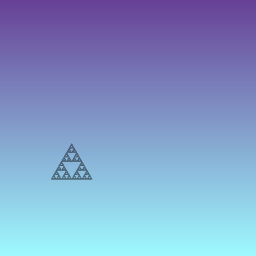

In [9]:
from IPython.display import Image
display(Image('/content/striangle.png', width=512, height=512))